# Prepare Spatial Objects

## Load environment

In [1]:
import os

import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq

In [2]:
data_dir = "/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/visium/GSE182939/"

## Load & Prepare objects

In [3]:
slides = os.listdir(data_dir)

In [4]:
adatas = dict()

In [5]:
for slide in slides:
    adata = sq.read.visium(path=data_dir + slide + '/outs')
    adata.var_names_make_unique()
    
    adata.obs["sample"] = slide
    
    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=400)
    sc.pp.filter_genes(adata, min_cells=5)
    
    # Additional QC
    adata.var['mt'] = adata.var_names.str.startswith('mt-') 
    adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
    adata.var['hb'] = adata.var_names.str.contains(("^Hb[^(P)]"))

    # Calculate qc
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
    
    adatas[slide] = adata

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/annd

### Additional Filtering

In [6]:
qc_metrics = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb']

In [7]:
qc_thresholds = pd.read_csv('/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/visium/' + 'qc_thresholds.csv', index_col=0)

In [8]:
qc_thresholds = qc_thresholds.transpose().to_dict()

In [9]:
qc_thresholds['f2dps_158_processed']

{'gene_thr_max': 6000.0,
 'gene_thr_min': 400.0,
 'total_thr': 25000.0,
 'mt_thr': 23.0,
 'ribo_thr': 23.0,
 'hb_thr': 0.4}

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify

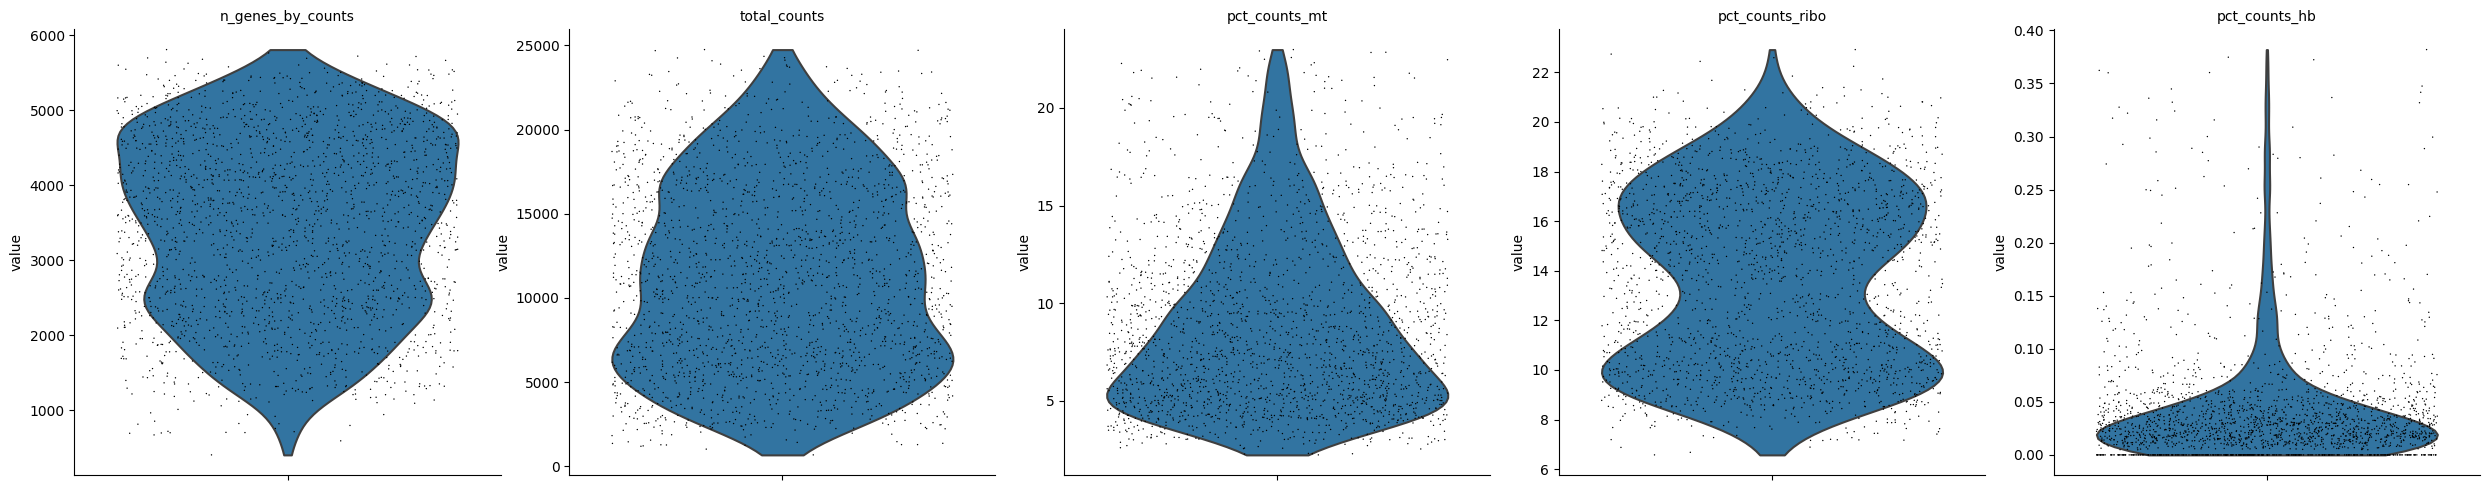

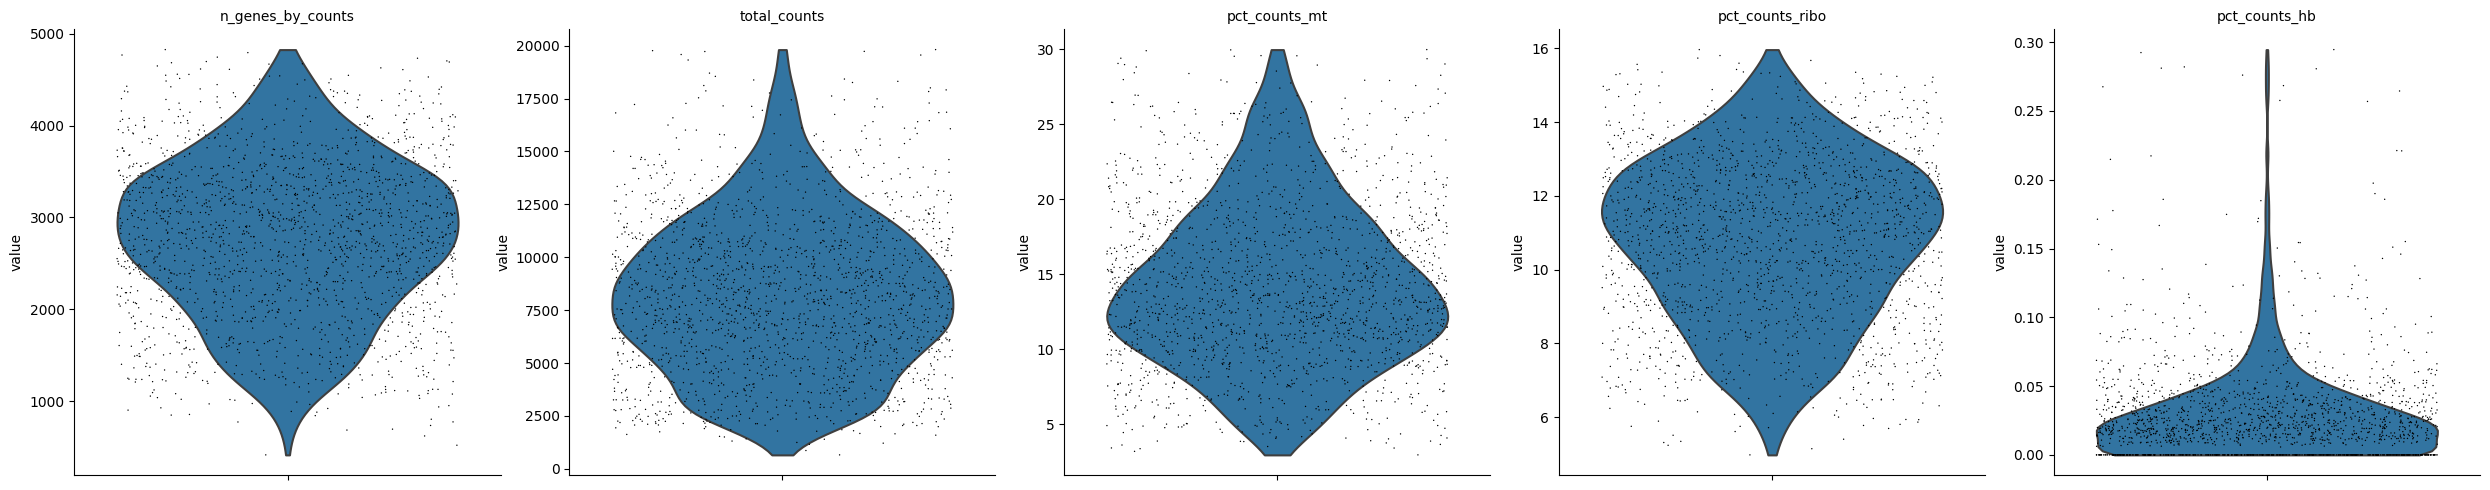

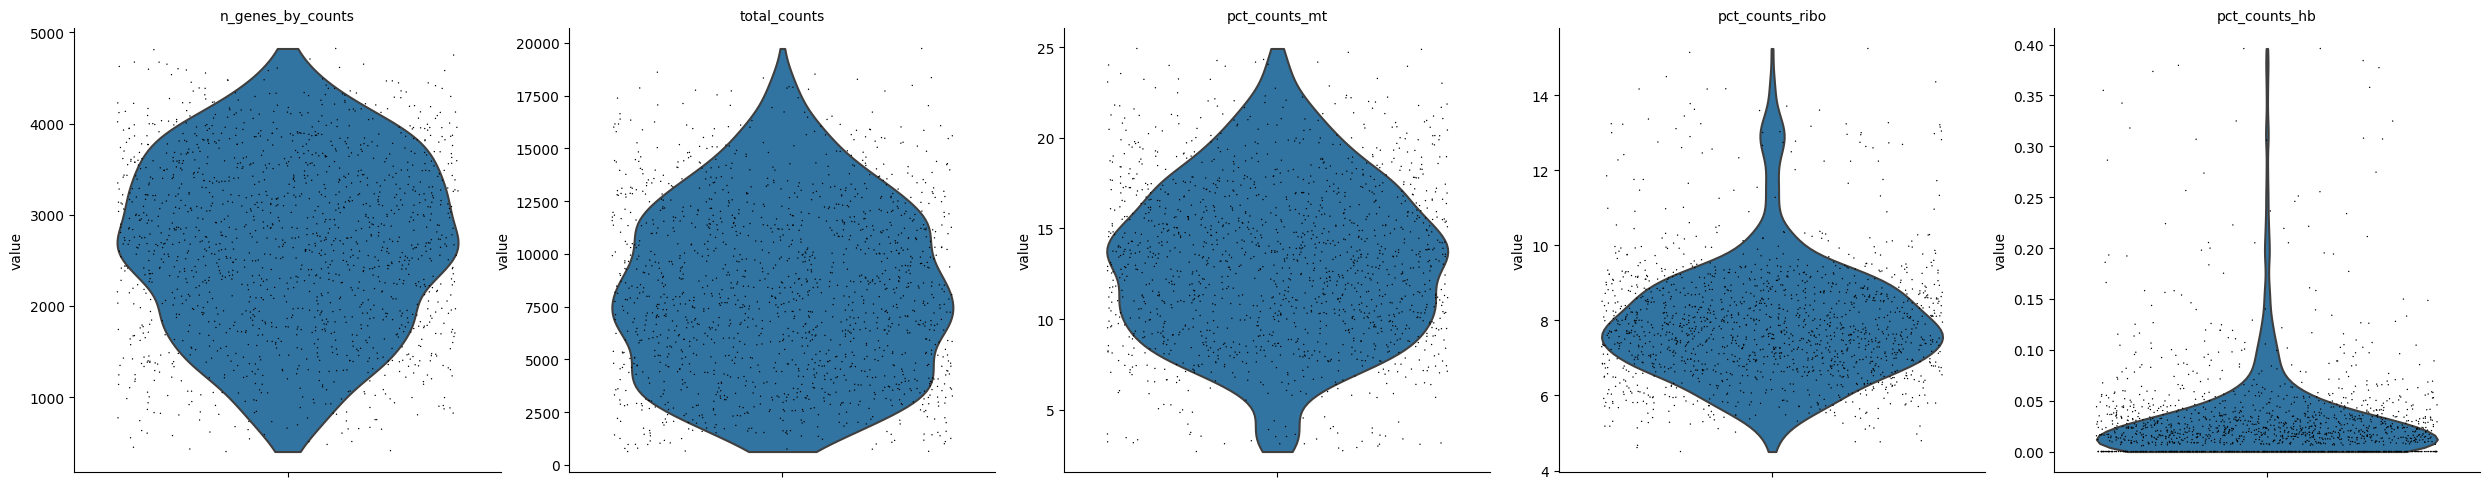

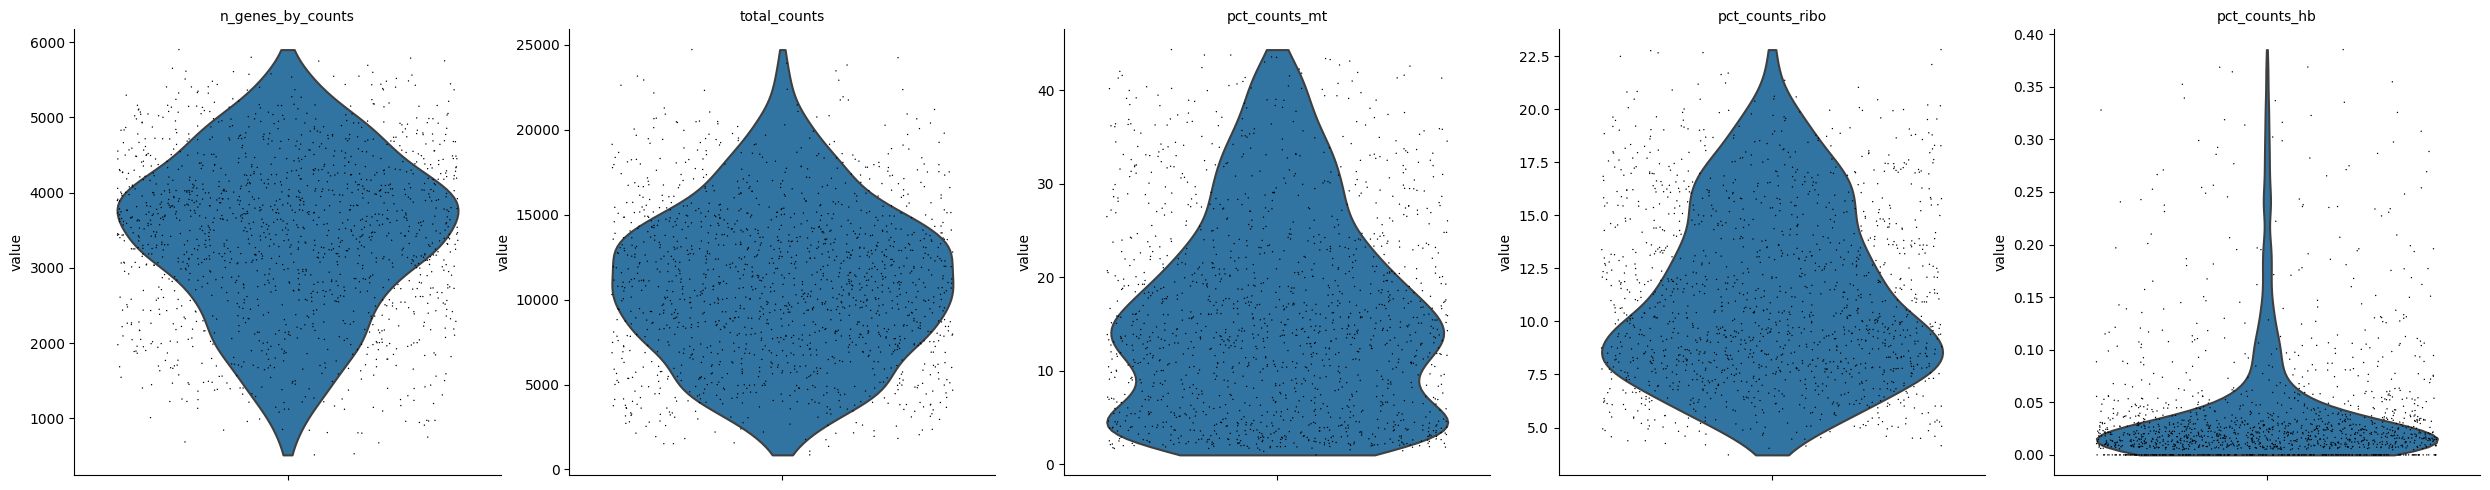

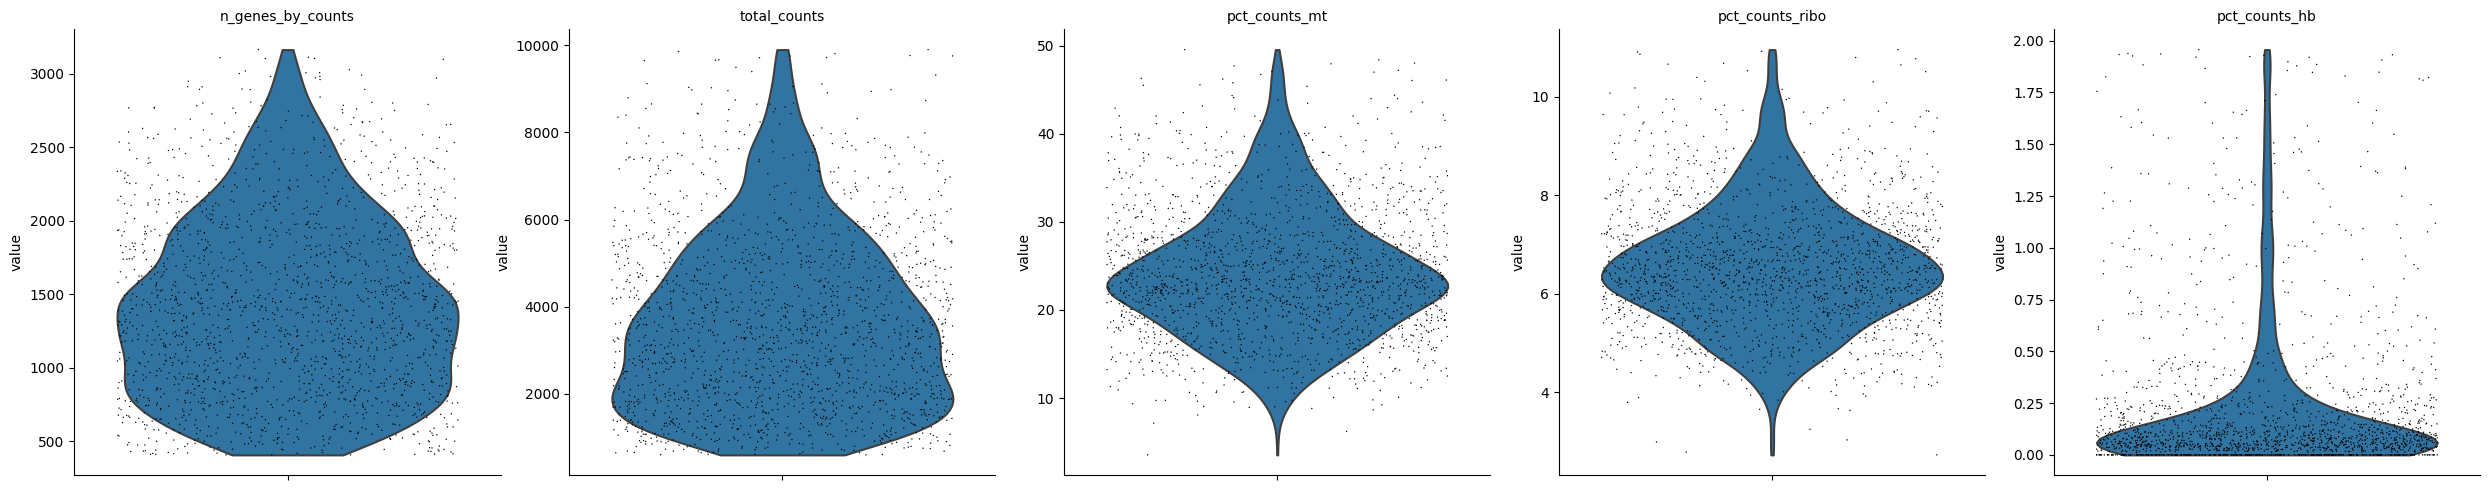

In [10]:
# Create mask
for slide in qc_thresholds.keys():
    
    adata = adatas[slide].copy()
    
    thr = qc_thresholds[slide]
    
    msk = (adata.obs['n_genes_by_counts'] < thr['gene_thr_max']) & \
        (adata.obs['n_genes_by_counts'] > thr['gene_thr_min']) & \
            (adata.obs['total_counts'] < thr['total_thr']) & \
            (adata.obs['pct_counts_mt'] < thr['mt_thr']) & \
            (adata.obs['pct_counts_ribo'] < thr['ribo_thr']) & \
            (adata.obs['pct_counts_hb'] < thr['hb_thr'])
    
    # Keep only non junk
    adatas[slide] = adata[msk, :]
    # Plot QC
    sc.pl.violin(adatas[slide], qc_metrics, jitter=0.4, rotation= 45, multi_panel=True, show=False)

In [11]:
adatas

{'f2dps_158_processed': AnnData object with n_obs × n_vars = 2111 × 15894
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 'f12hr_140_processed': AnnData object with n_obs × n_vars = 1816 × 14640
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 'fsham_137_processe

In [ ]:
adatas.keys()

In [ ]:
adatas

In [ ]:
for slide in adatas.keys():
    # Plot QC
    sc.pl.violin(adatas[slide], qc_metrics, jitter=0.4, rotation= 45, multi_panel=True, show=False)

In [ ]:
adatas

## Run LIANA

In [ ]:
import liana as li
from liana.method.sp import lr_basis, basis

In [ ]:
sq.gr.spatial_neighbors(adata, n_rings=2, coord_type="grid", n_neighs=6)

In [ ]:
adata.obsp["spatial_connectivities"]

In [ ]:
lr_basis(adata,
         function_name="pearson",
         expr_prop=0.1,
         resource_name="MouseConsensus", 
         pvalue_method=None, 
         use_raw=False, 
         positive_only=True,
         proximity_key="spatial_connectivities",
         )

In [ ]:
adata.uns['global_res'].sort_values('global_mean').tail(10)

In [ ]:
# save results as modalities
local_lr  = li.fun.obsm_to_adata(adata, 'local_scores')
# local_pvals = li.fun.obsm_to_adata(adata, 'local_pvals')

In [ ]:
sc.pl.spatial(local_lr, color=['Angptl4&Sdc4', 'Spp1&Itgav_Itgb1'], cmap='coolwarm')